## Understand Data

### Download Data

In [25]:
import torch
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
from helper_functions import PytorchModelTranier

RANDOM_SEED=42

In [26]:
train_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    download=True,
    target_transform=None,
    transform=torchvision.transforms.ToTensor()
)

In [27]:
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    download=True,
    target_transform=None,
    transform=torchvision.transforms.ToTensor()
)

### Understanding data

In [28]:
len(train_data), len(test_data), type(train_data)

(60000, 10000, torchvision.datasets.mnist.FashionMNIST)

In [29]:
image, label = train_data[0]
label, image

(9,
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.00

In [30]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [31]:
image.shape, type(image), label, type(label)

(torch.Size([1, 28, 28]), torch.Tensor, 9, int)

### Visualize data

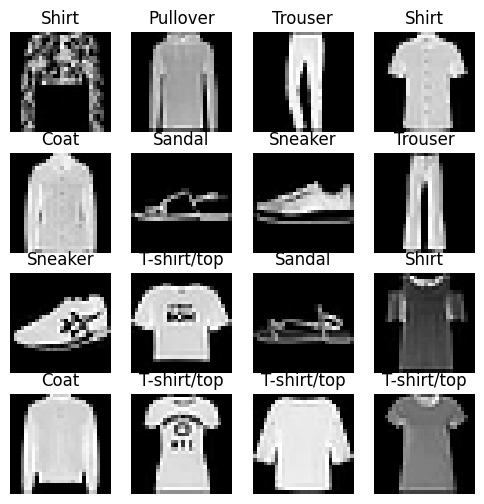

In [32]:
torch.manual_seed(RANDOM_SEED)
fig = plt.figure(figsize=(6,6))
rows, cols = 4 , 4
for i in range (rows * cols):
    idx = torch.randint(low=0, high=len(train_data)-1, size=(1,)).item()
    image, label = train_data[idx]
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

## Prepare DataLoader

In [33]:
from torch.utils.data import DataLoader

In [34]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

In [35]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"len of test and train data loader: {len(train_dataloader), len(test_dataloader)}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000229D60EDBB0>, <torch.utils.data.dataloader.DataLoader object at 0x00000229CE8A7CE0>)
len of test and train data loader: (1875, 313)


In [36]:
idx, (sample_train_batch, sample_train_label_batch) = next(enumerate(train_dataloader))
sample_train_batch.shape, sample_train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Create a baseline model

In [37]:
from torch import nn
from helper_functions import accuracy_fn, plot_loss_curves
import timer
from tqdm.auto import tqdm
NUM_CLASSES = len(train_data.classes)
HIDDEN_UNITS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [38]:
model_0 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=HIDDEN_UNITS),
    nn.Linear(in_features=HIDDEN_UNITS, out_features=NUM_CLASSES)
).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1,
)

model_0_trainer = PytorchModelTranier(
    name="v0-baseline-model",
    model=model_0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
)

 33%|███▎      | 1/3 [00:08<00:16,  8.05s/it]

Epoch 1/3 Train Loss: 0.5890 | Train Acc: 79.11% Test Loss: 0.5088 | Test Acc: 82.13%


 67%|██████▋   | 2/3 [00:15<00:07,  7.79s/it]

Epoch 2/3 Train Loss: 0.4787 | Train Acc: 83.01% Test Loss: 0.4941 | Test Acc: 82.52%


100%|██████████| 3/3 [00:24<00:00,  8.15s/it]

Epoch 3/3 Train Loss: 0.4562 | Train Acc: 83.99% Test Loss: 0.4673 | Test Acc: 83.38%


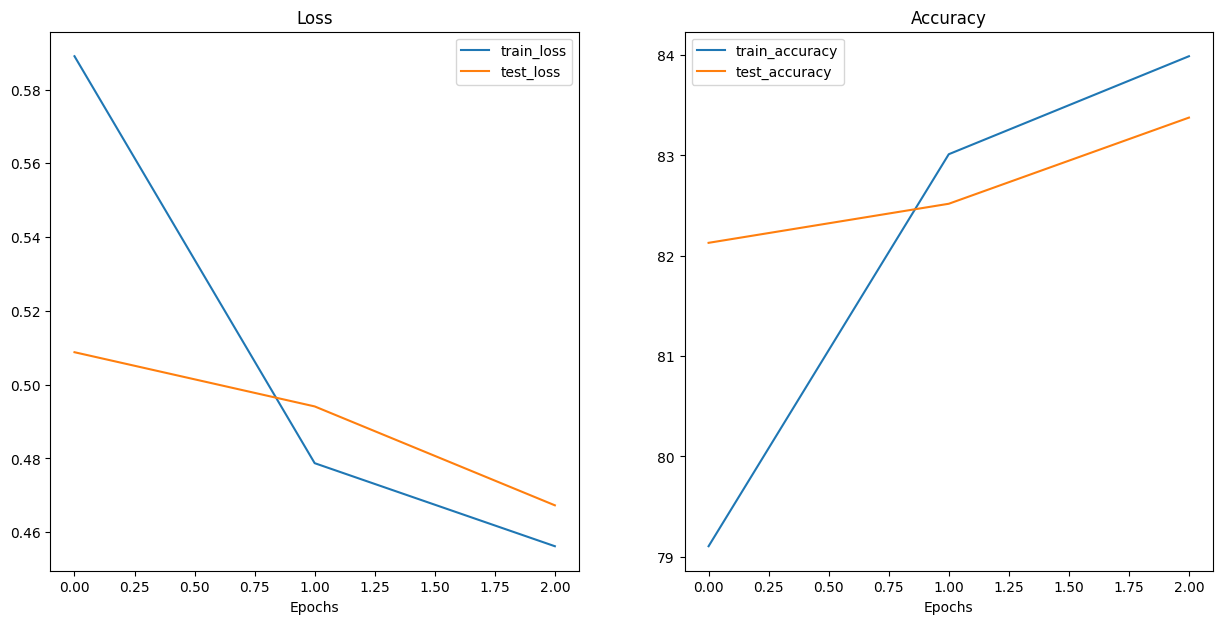

In [39]:
model_0_trainer.train(3)
model_0_trainer.plot_losses()

In [40]:
model_0_eval = model_0_trainer.eval()
model_0_eval

{'model_name': 'v0-baseline-model',
 'model_loss': 0.46729251742362976,
 'model_acc': 83.37659744408946}

 10%|█         | 1/10 [00:08<01:13,  8.17s/it]

Epoch 1/10 Train Loss: 0.7303 | Train Acc: 72.51% Test Loss: 0.5127 | Test Acc: 81.29%


 20%|██        | 2/10 [00:16<01:05,  8.21s/it]

Epoch 2/10 Train Loss: 0.4439 | Train Acc: 83.71% Test Loss: 0.4866 | Test Acc: 82.03%


 30%|███       | 3/10 [00:24<00:57,  8.27s/it]

Epoch 3/10 Train Loss: 0.3971 | Train Acc: 85.30% Test Loss: 0.4358 | Test Acc: 83.96%


 40%|████      | 4/10 [00:33<00:49,  8.28s/it]

Epoch 4/10 Train Loss: 0.3704 | Train Acc: 86.35% Test Loss: 0.4031 | Test Acc: 85.36%


 50%|█████     | 5/10 [00:41<00:41,  8.28s/it]

Epoch 5/10 Train Loss: 0.3535 | Train Acc: 86.83% Test Loss: 0.4156 | Test Acc: 84.74%


 60%|██████    | 6/10 [00:49<00:33,  8.28s/it]

Epoch 6/10 Train Loss: 0.3388 | Train Acc: 87.36% Test Loss: 0.4241 | Test Acc: 85.25%


 70%|███████   | 7/10 [00:58<00:25,  8.37s/it]

Epoch 7/10 Train Loss: 0.3267 | Train Acc: 87.91% Test Loss: 0.3844 | Test Acc: 86.13%


 80%|████████  | 8/10 [01:06<00:16,  8.38s/it]

Epoch 8/10 Train Loss: 0.3164 | Train Acc: 88.28% Test Loss: 0.3851 | Test Acc: 86.02%


 90%|█████████ | 9/10 [01:15<00:08,  8.49s/it]

Epoch 9/10 Train Loss: 0.3094 | Train Acc: 88.35% Test Loss: 0.3668 | Test Acc: 86.92%


100%|██████████| 10/10 [01:23<00:00,  8.38s/it]

Epoch 10/10 Train Loss: 0.3022 | Train Acc: 88.65% Test Loss: 0.4032 | Test Acc: 86.07%


{'model_name': 'v1-with-non-linear-layers-model', 'model_loss': 0.40315932035446167, 'model_acc': 86.07228434504792}


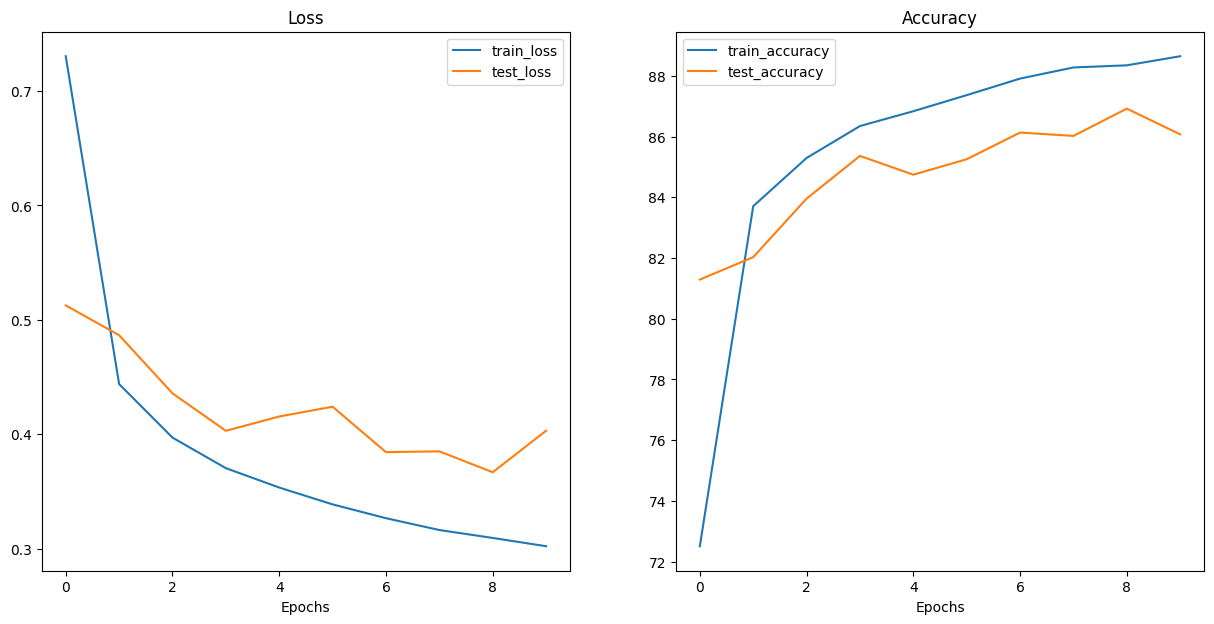

In [42]:
model_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=10)
).to(device)

model_1_trainer = PytorchModelTranier(
    name="v1-with-non-linear-layers-model",
    model=model_1,
    loss_fn=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(
        params=model_1.parameters(),
        lr=0.1,
    ),
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
)

model_1_trainer.train(10)

model_1_eval = model_1_trainer.eval()
print(model_1_eval)

model_1_trainer.plot_losses()

## Create CNN Model

In [57]:
class FashionMNISTV2(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_shape):
        super().__init__()
        self.conv_l1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_l2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(
                # in_features=0,
                out_features=output_shape,
            )
        )

    def forward(self, x):
        # print("original data shape", x.shape)
        x = self.conv_l1(x)
        # print("shape after conv l1", x.shape)
        x = self.conv_l2(x)
        # print("shape after conv l2", x.shape)
        x = self.classifier(x)
        # print("shape after classifier", x.shape)
        return x

In [ ]:
model_2 = FashionMNISTV2(
    hidden_channels=10,
    input_channels=1,
    output_shape=len(train_data.classes)
).to(device)

model_2_trainer = PytorchModelTranier(
    name="v2-with-conv-layers-model",
    model=model_2,
    loss_fn=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(
        params=model_2.parameters(),
        lr=0.1,
    ),
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
)

# model_2.eval()
# with torch.inference_mode():
#     y_logits = model_2(next(iter(test_dataloader))[0])
# y_logits

In [ ]:
model_2_trainer.train(10)

model_2_eval = model_2_trainer.eval()
print(model_2_eval)

model_2_trainer.plot_losses()

  0%|          | 0/1 [00:00<?, ?it/s]